In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

# import sys
# sys.path.append("../derrom")
# import derrom
# from derrom.utils import ivp_integrator
# import PHELPH

# # data_path = '../data_PHELPH/'
# data_path = '../data/'

data_path = "../../../data_PHELPH/"
derrom_path = "../../"

import sys

# sys.path.append(derrom_path)
sys.path.insert(0,derrom_path)

import derrom
from derrom.utils import ivp_integrator
import PHELPH

In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
dt = tmax/(n_tmax-1)
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.04
system.tau_photon = 200
system.E_photon = 0.035
system.linewidth = 0.01

system.setup_laser()

In [3]:
I_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_I_kmax2.5_nkmax_100_n1000_v2.npz')
el_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_kmax2.5_nkmax_100_n1000_v2.npz')
el_scattering = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_scat_kmax2.5_nkmax_100_n1000_v2.npz')

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]
print(n_trajectories, 'loaded with n_kmax =', n_kmax)

mean_I_max = np.mean([I.max() for I in I_trajectories])
mean_I_max_pos = np.mean([np.argmax(I)*dt for I in I_trajectories])

median_I_max = np.median([I.max() for I in I_trajectories])
median_I_max_pos = np.median([np.argmax(I)*dt for I in I_trajectories])

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

# n_sample = 100
# I_trajectories = I_trajectories[::n_sample]
# el_trajectories = el_trajectories[::n_sample]
# el_scattering = el_scattering[::n_sample]

n_sample = 50
n_start = 0

train_I_trajectories = I_trajectories[n_start:n_start+n_sample]
train_el_trajectories = el_trajectories[n_start:n_start+n_sample]
train_el_scattering = el_scattering[n_start:n_start+n_sample]
train_trajectories = trajectories[n_start:n_start+n_sample]
print('number of training trajectories: ', len(train_trajectories))

test_start = n_sample
test_I_trajectories = I_trajectories[test_start:]
test_el_trajectories = el_trajectories[test_start:]
test_el_scattering = el_scattering[test_start:]
test_trajectories = trajectories[test_start:]
print('number of test trajectories: ', len(test_trajectories))

median_test_I_max = np.median([I.max() for I in test_I_trajectories])
median_test_I_max_pos = np.median([np.argmax(I)*dt for I in test_I_trajectories])

1000 loaded with n_kmax = 100
number of training trajectories:  50
number of test trajectories:  950


In [4]:
el_scat_model_self_con_I = derrom.utils.load_model(data_path+'el_scat_model_self_con_I.obj')

def derivs_self_con_I(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = el_scat_model_self_con_I.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))


integrator_self_con_I = derrom.utils.PHELPH_ivp_integrator(el_scat_model_self_con_I, derivs_self_con_I, dt=5.0, dt_out=10., method='Heun')

In [5]:
el_scat_model = derrom.estimator(rdim=8, DE_l=2, intercept=True, full_hist=False,
                    optimizer=derrom.optimizers.ridge(alpha=10.**1),
                    scaler=derrom.scalers.standardize_scaler(1.0),
                    dim_reducer=derrom.dim_reducers.SVD(),
                    NL_transformer=derrom.transformers.ELM_features(ELM_nodes=1000))

def derivs(y):   
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]

    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)


    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9

    return np.concatenate((df[0],[dI]))

integrator = derrom.utils.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

In [6]:
el_scat_model.fit(train_el_trajectories, train_el_scattering)

In [7]:
el_scat_model.print_status()

full_hist:  True
intercept:  True
standardize:  True
rdim:  8
DE_l:  2
weights shape:  (1017, 100)


data driven:
el rms error: 0.002908421658725121
I_max error: -0.01603913667942174
I_max_pos error: 0.010362694300518135

two temperature approximation:
el rms error: 0.06342355339185898
I_max error: -0.600632732185853
I_max_pos error: 0.10880829015544041


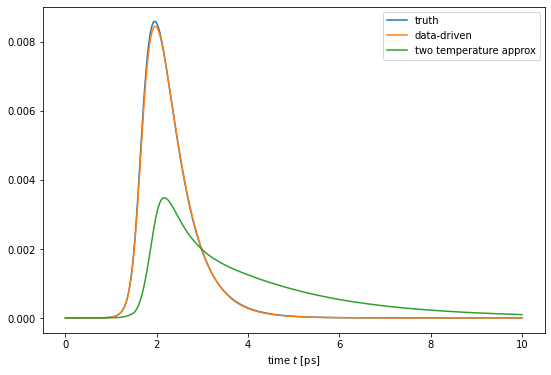

In [9]:
ind = -29  ### -1, -9, -20, -28, -29

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]

# inits = test_trajectory[:1]

pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])

ttrt_inits = np.concatenate([test_trajectory[0,:system.n_kmax],[system.T_cryo],[test_trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)


plt.plot(t_vec/1000,test_I_trajectory,label='truth')
plt.plot(t_vec/1000,pred[:,-1],label='data-driven')
plt.plot(t_vec/1000,ttrt_approx[:,-1],label='two temperature approx')

print('data driven:')
print('el rms error:', integrator.get_error(test_trajectory,pred, norm='rms'))
print('I_max error:', integrator.get_error(test_trajectory,pred, norm='I_max')/median_I_max)
print('I_max_pos error:', integrator.get_error(test_trajectory,pred, norm='I_max_pos')/median_I_max_pos)

ttrta_tmp = np.concatenate([ttrt_approx[:,:-2],ttrt_approx[:,-1:]],axis=1)
print('\ntwo temperature approximation:')
print('el rms error:', integrator.get_error(test_trajectory,ttrta_tmp, norm='rms'))
print('I_max error:', integrator.get_error(test_trajectory,ttrta_tmp, norm='I_max')/median_I_max)
print('I_max_pos error:', integrator.get_error(test_trajectory,ttrta_tmp, norm='I_max_pos')/median_I_max_pos)


plt.xlabel(r'time $t$ [ps]')
plt.legend()
plt.show()


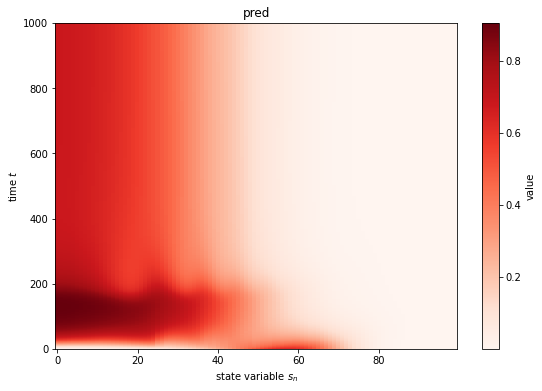

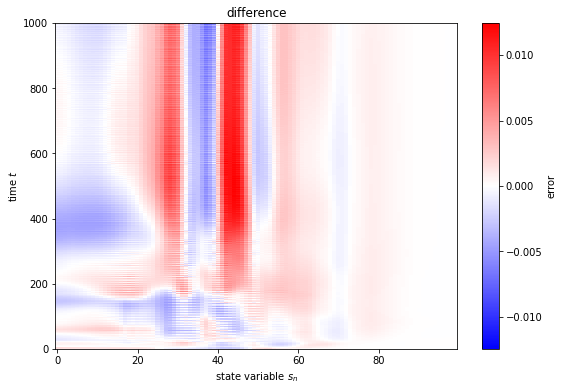

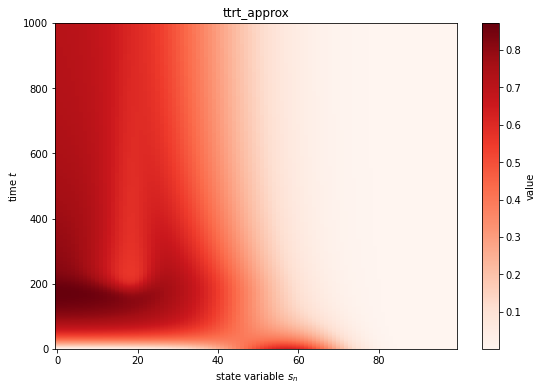

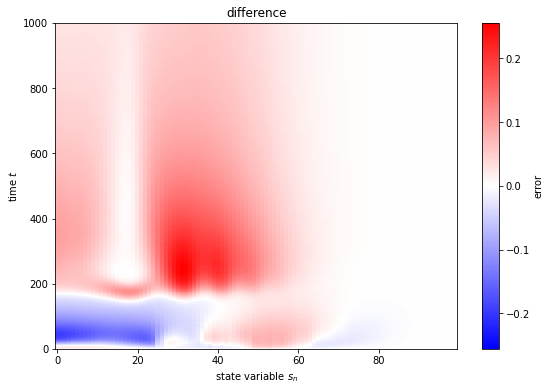

In [10]:
derrom.utils.plot_trajectory(pred[:,:-1],title='pred')
derrom.utils.plot_difference(truth=test_el_trajectory,test=pred[:,:-1])

derrom.utils.plot_trajectory(ttrt_approx[:,:-2],title='ttrt_approx')
derrom.utils.plot_difference(truth=test_el_trajectory,test=ttrt_approx[:,:-2])

0.1602084583831674


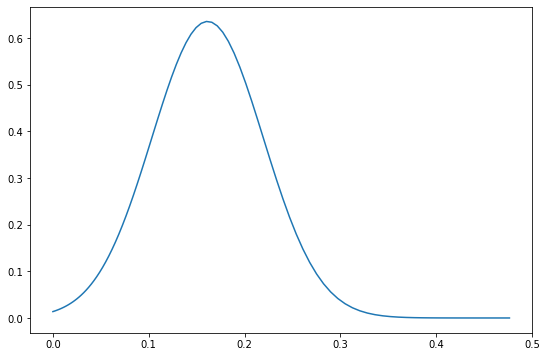

In [11]:
print(system.E_el_vec[np.argmax(test_el_trajectory[0])])

plt.plot(system.E_el_vec,test_el_trajectory[0])
plt.show()

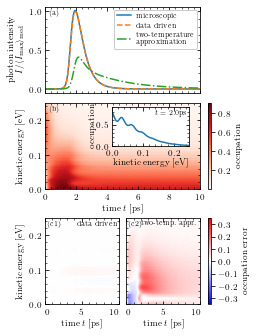

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors

fs = 9
fig = plt.figure(figsize=(3.40457,4.7))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1,1,0.05], height_ratios=[1,1,0.1,1])



####################################################
####################################################
####################################################
norm = median_I_max

ax00 = plt.subplot(gs[0,:2])

plt.plot(t_vec/1000,test_I_trajectory/norm,label='microscopic')
plt.plot(t_vec/1000,pred[:,-1]/norm,'--',label='data driven')
plt.plot(t_vec/1000,ttrt_approx[:,-1]/norm,'-.',label='two-temperature\napproximation')

plt.xlim(0,10)

# plt.legend(fontsize = fs-2, loc='upper right', bbox_to_anchor=(1.3, 0.95),framealpha=1.0)
plt.legend(fontsize = fs-2, loc='upper right',framealpha=1.0)

# plt.xlabel(r'time $t$ [ps]')
plt.ylabel('photon intensity\n' + r'$I/ \langle I_{\rm max} \rangle_{\rm med}$')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax00.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.4))
ax00.xaxis.set_major_formatter(ticker.NullFormatter())
ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(a)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)

####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[1,:2])

im = plt.pcolormesh(t_vec/1000,system.E_el_vec,test_el_trajectory.T, cmap='Reds', shading='auto', rasterized=True)

plt.ylim(0,0.25)

plt.xlabel(r'time $t$ [ps]')
plt.ylabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax00.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.4))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)


####################################################
axCB = plt.subplot(gs[1,2])

cb = plt.colorbar(im, cax = axCB)
cb.set_label("occupation")

axCB.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
# axCB.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

####################################################

axins = ax00.inset_axes([0.43, 0.5, 0.50, 0.45])

axins.plot(system.E_el_vec, test_el_trajectory[200])

axins.set_xlabel('kinetic energy [eV]', labelpad=1,fontsize=fs)
axins.set_ylabel('occupation',labelpad=0,fontsize=fs)
axins.set_xlim(0,0.25)
axins.set_ylim(0,0.9)

axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.tick_params(which='both', direction='in', color='k')

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

axins.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.97, 0.92,r'$t=2.0$ps', horizontalalignment='right', verticalalignment='top', transform=axins.transAxes, fontsize=fs-2)

####################################################
####################################################
####################################################

norm = colors.CenteredNorm(0.0, halfrange=0.35)
# norm = colors.SymLogNorm(linthresh=0.03, linscale=0.1)

ax00 = plt.subplot(gs[3,0])


im = plt.pcolormesh(t_vec/1000,system.E_el_vec,pred[:,:-1].T - test_el_trajectory.T,norm=norm, cmap='bwr', shading='auto', rasterized=True)

plt.ylim(0,0.25)

plt.xlabel(r'time $t$ [ps]')
plt.ylabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

ax00.get_xticklabels(which='major')[1].set(horizontalalignment='left')
ax00.get_xticklabels(which='major')[-2].set(horizontalalignment='right')

plt.text(0.03, 0.97,r'(c1)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)
plt.text(0.97, 0.97,r'data driven', horizontalalignment='right', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)

####################################################

ax00 = plt.subplot(gs[3,1])


im = plt.pcolormesh(t_vec/1000,system.E_el_vec,ttrt_approx[:,:-2].T - test_el_trajectory.T,norm=norm, cmap='bwr', shading='auto', rasterized=True)

plt.ylim(0,0.25)

plt.xlabel(r'time $t$ [ps]')
# plt.ylabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax00.yaxis.set_major_formatter(ticker.NullFormatter())
ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

ax00.get_xticklabels(which='major')[1].set(horizontalalignment='left')
ax00.get_xticklabels(which='major')[-2].set(horizontalalignment='right')

plt.text(0.03, 0.97,r'(c2)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)
plt.text(0.97, 0.97,r'two-temp. appr.', horizontalalignment='right', verticalalignment='top', transform=ax00.transAxes, fontsize=fs-2)

####################################################

axCB = plt.subplot(gs[3,2])

cb = plt.colorbar(im, cax = axCB)
cb.set_label("occupation error")

axCB.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# axCB.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

####################################################
####################################################
####################################################


# plt.tight_layout()

plt.subplots_adjust(left=0.16, bottom=0.09, right=0.84, top=0.97, wspace=0.15, hspace=0.15)

# plt.savefig('../../../dynamics_approx_example.pdf', dpi=600)
plt.show()